In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from ridge import RidgeRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Now Lets test on the olympic dataset

We have to note that we the data is temporal. That being said, we have to be extremely careful, on how we do the split, because there a temporal dependency, if we give the model the futur and ask it to predict the past it would do very well, but that's data leakage. So we use TimeSeriesSplit, which is a form of cross validation but it works in the following manner, which does not mess up the time dependencies.
```
tra tra tra tra tes xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx
tra tra tra tra tra tra tra tra tes tes xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx
tra tra tra tra tra tra tra tra tra tra tra tes tes tes xxx xxx xxx xxx xxx xxx xxx
tra tra tra tra tra tra tra tra tra tra tra tra tra tra tra tra tra tes tes tes tes
```
We do a normalization for the years 
$$year=\frac{(year-\mu)}{\sigma}$$
where $\mu$ is the mean of the years and $\sigma$ is the standard deviation.<br>

How do we tune for alpha?<br>
=> We take the alpha which has the best TimeSeriesSplit cross validation score. We do a grid search for that, we have to keep in mind that increasing alpha will result in a simpler model i.e that bias will go up and the variance will go down by imposing a penaly on the weights.<br>
We also introduced afterwards polynomial features to better fit the data which is not really linear. we chose degree 2 because a higher degree would result in overfitting the data(which is very simple and very scarce in our case)

In [4]:
df = pd.read_csv("Olympic.csv")
# We leave 2 points for testing as data is scarce we can't affort leaving out too many points, otherwise the model wouldn't be able to capture
# the pattern in the data
train_df = df[:-2]
test_df = df[-2:]

X_train_valid = train_df[['Year']].values
y_train_valid = train_df['Time'].values
X_test = test_df[['Year']].values
y_test = test_df['Time'].values

scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train_valid)
X_test_scaled = scaler.transform(X_test)
# we found this value of alpha by setting the polynomial features to one in the next cell code and doing grid search
model =  RidgeRegression(alpha=0.8)


tscv = TimeSeriesSplit(n_splits=5) 
mse_scores = []

for train_index, valid_index in tscv.split(X_train_scaled):
    X_train, X_valid = X_train_scaled[train_index], X_train_scaled[valid_index]
    y_train, y_valid = y_train_valid[train_index], y_train_valid[valid_index]

    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)

    mse = mean_squared_error(y_valid, predictions)
    mse_scores.append(mse)

average_mse = sum(mse_scores) / len(mse_scores)
print("MSE's per fold:",mse_scores)
print("Average MSE across all folds:", average_mse)

MSE's per fold: [0.07537464742823477, 0.0440538719113998, 0.04678182458500203, 0.011820186253465483, 0.011524888859856955]
Average MSE across all folds: 0.037911083807591804


In [5]:
X_test = test_df[['Year']].values
y_test = test_df['Time'].values
model.fit(X_train_scaled, y_train_valid)
train_predictions=model.predict(X_train_scaled)
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
mse

0.0639490444919544

In [6]:
#Scikit learn's model
model = Ridge(alpha=0.8)
model.fit(X_train_scaled, y_train_valid)

predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
mse

0.0639490444919544

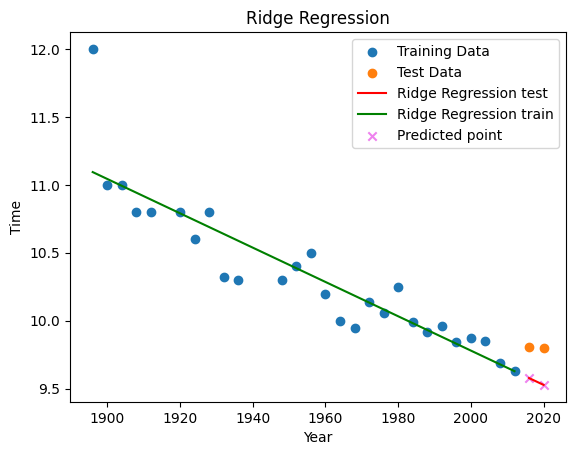

In [7]:
plt.scatter(X_train_valid, y_train_valid, label='Training Data')
plt.scatter(X_test, y_test, label='Test Data')
plt.plot(X_test, predictions, color='red', label='Ridge Regression test')
plt.plot(X_train_valid, train_predictions, color='green', label='Ridge Regression train')
plt.scatter(X_test, predictions, color='violet', marker='x', label='Predicted point')



plt.xlabel('Year')
plt.ylabel('Time')
plt.title('Ridge Regression')
plt.legend()
plt.show()

### Now lets do some feature transaformation so that we could have a better model 

In [11]:
X = df[['Year']].values
y = df['Time'].values
train_df = df[:-2]
test_df = df[-2:]

X_train_valid = train_df[['Year']].values
y_train_valid = train_df['Time'].values
X_test = test_df[['Year']].values
y_test = test_df['Time'].values


scaler = StandardScaler()
X_train_valid_scaled = scaler.fit_transform(X_train_valid)
poly = PolynomialFeatures(degree=2)
X_train_valid_poly = poly.fit_transform(X_train_valid_scaled)


# Grid search to find alpha
alpha_range = np.arange(0.1, 10.1, 0.1)  
best_alpha = None
best_mse = float('inf')

for alpha in alpha_range:
        model = RidgeRegression(alpha=alpha)

        tscv = TimeSeriesSplit(n_splits=5)
        mse_scores = []

        for train_index, valid_index in tscv.split(X_train_valid_poly):
            X_train, X_valid = X_train_valid_poly[train_index], X_train_valid_poly[valid_index]
            y_train, y_valid = y_train_valid[train_index], y_train_valid[valid_index]

            model.fit(X_train, y_train)
            predictions = model.predict(X_valid)


            mse = mean_squared_error(y_valid, predictions)
            mse_scores.append(mse)

        average_mse = sum(mse_scores) / len(mse_scores)

        if average_mse < best_mse:
            best_mse = average_mse
            best_alpha = alpha

print(f"Best Alpha: {best_alpha}")
print(f"Best Average MSE: {best_mse}")


Best Alpha: 0.7000000000000001
Best Average MSE: 0.06364962337477667


In [9]:
model = RidgeRegression(alpha=0.7)
poly = PolynomialFeatures(degree=2)
X_train_valid_poly = poly.fit_transform(X_train_valid_scaled)
X_test_scaled=scaler.transform(X_test)
X_test_poly = poly.transform(X_test_scaled)

# Final evaluation on the test set
model.fit(X_train_valid_poly, y_train_valid)
final_predictions = model.predict(X_test_poly)
final_mse = mean_squared_error(y_test, final_predictions)
print("Final MSE on test set:", final_mse)

Final MSE on test set: 6.543853344120817e-06


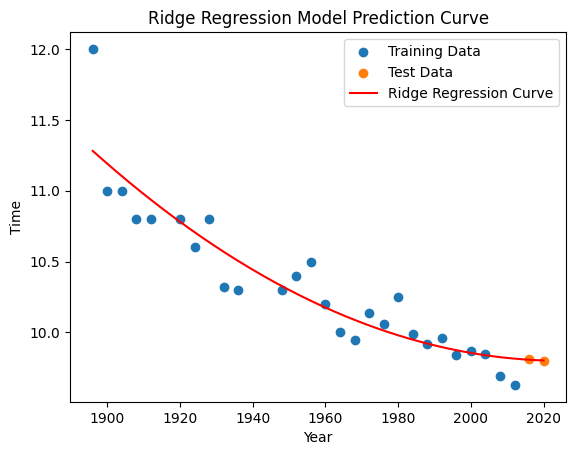

In [10]:
year_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
year_range_scaled = scaler.transform(year_range)
year_range_poly = poly.transform(year_range_scaled)

predictions_range = model.predict(year_range_poly)


plt.scatter(X_train_valid, y_train_valid, label='Training Data')
plt.scatter(X_test, y_test, label='Test Data')
plt.plot(year_range, predictions_range, color='red', label='Ridge Regression Curve')

plt.xlabel('Year')
plt.ylabel('Time')
plt.title('Ridge Regression Model Prediction Curve')
plt.legend()
plt.show()
